Imports and Dataset

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
import tabulate
from tabulate import tabulate
from sklearn.svm import SVC



# Load the dataset
df = pd.read_csv('df_model.csv')  # Replace with your dataset's path



Process the data

In [4]:
# Define the feature matrix (X) and the target variable (y)
X = df.drop(columns=['loan_status'])  # Drop the target column
y = df['loan_status']

# Normalize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a bias term (intercept) to the feature matrix
X_scaled = np.hstack((np.ones((X_scaled.shape[0], 1)), X_scaled))

# Convert target to -1 and 1 for SVM/Perceptron compatibility
y = np.where(y == 0, -1, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Verify the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (31489, 30)
X_test shape: (13496, 30)
y_train shape: (31489,)
y_test shape: (13496,)


Custom Perceptron and SVM Implementation

Perceptron Class

In [5]:
class Perceptron:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.w = None

    def fit(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n)
        for _ in range(self.epochs):
            for i in range(m):
                if y[i] * (X[i] @ self.w) <= 0:
                    self.w += self.learning_rate * y[i] * X[i]

    def predict(self, X):
        return np.sign(X @ self.w)


SVM Class



In [6]:
class SVM:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.w = None

    def fit(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n)
        for _ in range(self.epochs):
            for i in range(m):
                if y[i] * (X[i] @ self.w) < 1:
                    self.w += self.learning_rate * (y[i] * X[i])
                else:
                    self.w -= self.learning_rate * (0.01 * self.w)

    def predict(self, X):
        return np.sign(X @ self.w)


Training and Prediction

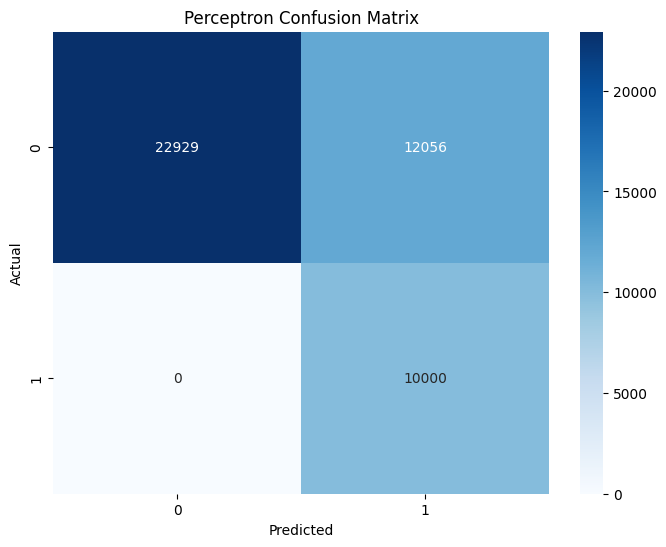

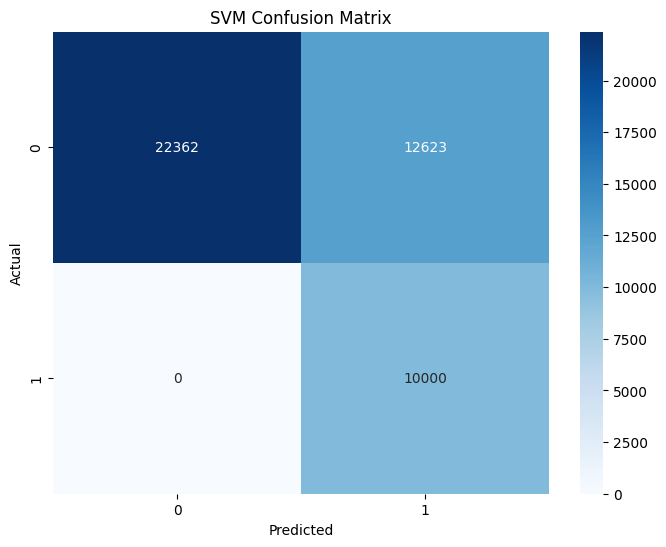

In [8]:
# Ensure intercept column is added to X_with_intercept
X_with_intercept = np.hstack((np.ones((X_scaled.shape[0], 1)), X_scaled))

# Train Custom Perceptron
perceptron = Perceptron(learning_rate=0.01, epochs=1000)
perceptron.fit(X_with_intercept, y)
perceptron_predictions = perceptron.predict(X_with_intercept)

# Train Custom SVM
svm = SVM(learning_rate=0.01, epochs=1000)
svm.fit(X_with_intercept, y)
svm_predictions = svm.predict(X_with_intercept)

# plot the confusion matrix for both og them


# Custom Perceptron Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y, perceptron_predictions), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Perceptron Confusion Matrix')
plt.show()

# Custom SVM Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y, svm_predictions), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()




Visualization Function

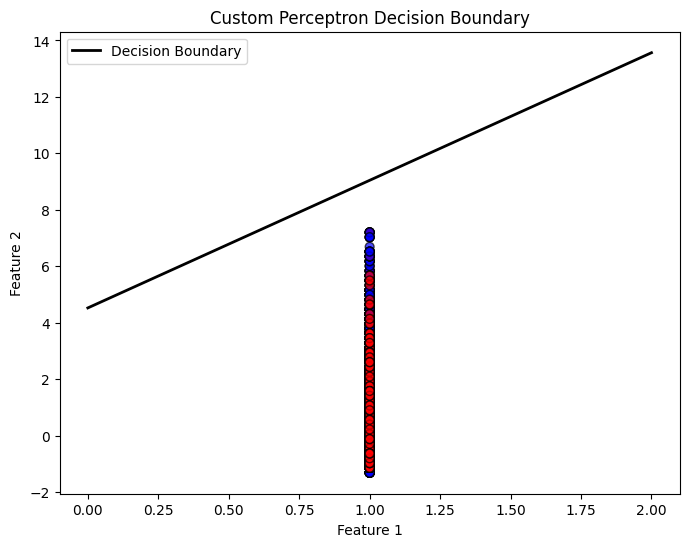

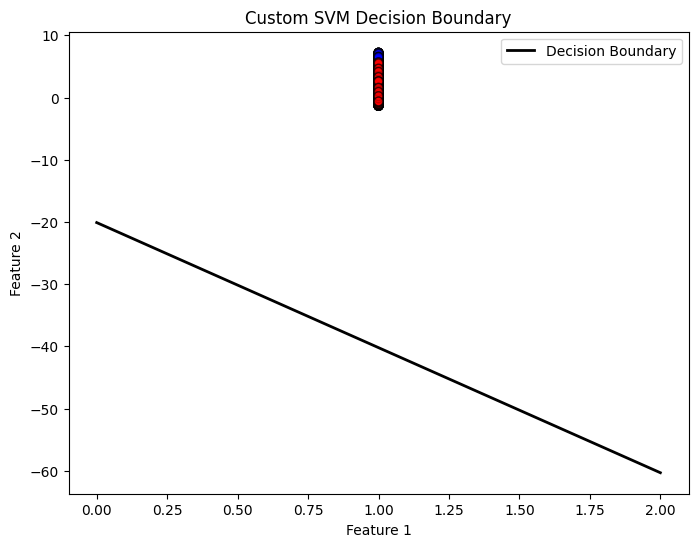

In [11]:
def plot_decision_boundary_scatter(X, y, model, title):
    # Convert to NumPy if X is a DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    
    plt.figure(figsize=(8, 6))
    
    # Plot data points
    plt.scatter(X[:, 1], X[:, 2], c=y, cmap='bwr', alpha=0.7, edgecolors='k', s=40)
    
    # Compute decision boundary
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x_values = np.linspace(x_min, x_max, 100)
    
    # For a linear decision boundary: w0 + w1*x + w2*y = 0 => y = -(w0 + w1*x) / w2
    w = model.w
    if w[2] != 0:  # To avoid division by zero
        y_values = -(w[0] + w[1] * x_values) / w[2]
        plt.plot(x_values, y_values, 'k-', linewidth=2, label='Decision Boundary')
    else:
        plt.axvline(-w[0] / w[1], color='k', linestyle='--', label='Vertical Boundary')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Plot decision boundaries
plot_decision_boundary_scatter(X_with_intercept, y, perceptron, 'Custom Perceptron Decision Boundary')
plot_decision_boundary_scatter(X_with_intercept, y, svm, 'Custom SVM Decision Boundary')


Training with Scikit-Learn

In [12]:
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.svm import LinearSVC

# Train Perceptron using Scikit-learn
perceptron_model = SklearnPerceptron(max_iter=1000)
perceptron_model.fit(X, y)
w_perceptron_sklearn = np.hstack((perceptron_model.intercept_, perceptron_model.coef_.flatten()))

# Train SVM using Scikit-learn
svm_model = LinearSVC(loss='hinge', max_iter=1000)
svm_model.fit(X, y)
w_hinge_sklearn = np.hstack((svm_model.intercept_, svm_model.coef_.flatten()))


Comparison Table

In [14]:
import pandas as pd

# Ensure weights are NumPy arrays and have the correct size
perceptron_weights = perceptron.w.flatten()[:3]  # Extract first three weights
svm_weights = svm.w.flatten()[:3]  # Extract first three weights
sklearn_perceptron_weights = w_perceptron_sklearn[:3]
sklearn_svm_weights = w_hinge_sklearn[:3]

# Create the comparison table
comparison_table = pd.DataFrame({
    'Weights': ['Intercept', 'Feature 1', 'Feature 2'],
    'Perceptron (Scratch)': perceptron_weights,
    'Perceptron (sklearn)': sklearn_perceptron_weights,
    'SVM (Scratch)': svm_weights,
    'SVM (sklearn)': sklearn_svm_weights
})

print(comparison_table)


     Weights  Perceptron (Scratch)  Perceptron (sklearn)  SVM (Scratch)  \
0  Intercept             -0.340000                2953.0       0.266388   
1  Feature 1             -0.340000               78821.0       0.266388   
2  Feature 2              0.075191             -180438.0       0.013251   

   SVM (sklearn)  
0       0.000050  
1       0.000736  
2      -0.000031  


Hyperparameter Tuning and Visualization

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Grid Search for Perceptron
param_grid_perceptron = {'max_iter': [500, 1000, 2000], 'eta0': [0.001, 0.01, 0.1]}
grid_perceptron = GridSearchCV(SklearnPerceptron(), param_grid_perceptron, cv=3)
grid_perceptron.fit(X, y)
best_perceptron = grid_perceptron.best_estimator_

# Grid Search for SVM
param_grid_svm = {'C': [0.1, 1, 10]}
grid_svm = GridSearchCV(LinearSVC(loss='hinge', max_iter=1000), param_grid_svm, cv=3)
grid_svm.fit(X, y)
best_svm = grid_svm.best_estimator_

# Print Best Parameters
print("Best parameters for Perceptron:", grid_perceptron.best_params_)
print("Best parameters for SVM:", grid_svm.best_params_)


Best parameters for Perceptron: {'eta0': 0.001, 'max_iter': 500}
Best parameters for SVM: {'C': 1}


Performance Metrics


Accuracy Scores Comparison:
+--------------------+--------------------+
|       Model        |      Accuracy      |
+--------------------+--------------------+
| Custom Perceptron  | 0.7319995554073581 |
|     Custom SVM     | 0.7193953540068911 |
| Sklearn Perceptron | 0.7792152939868845 |
|    Sklearn SVM     | 0.8198288318328332 |
+--------------------+--------------------+
Custom Perceptron Metrics:
              precision    recall  f1-score   support

          -1       1.00      0.66      0.79     34985
           1       0.45      1.00      0.62     10000

    accuracy                           0.73     44985
   macro avg       0.73      0.83      0.71     44985
weighted avg       0.88      0.73      0.75     44985

Custom SVM Metrics:
              precision    recall  f1-score   support

          -1       1.00      0.64      0.78     34985
           1       0.44      1.00      0.61     10000

    accuracy                           0.72     44985
   macro avg       0.72    

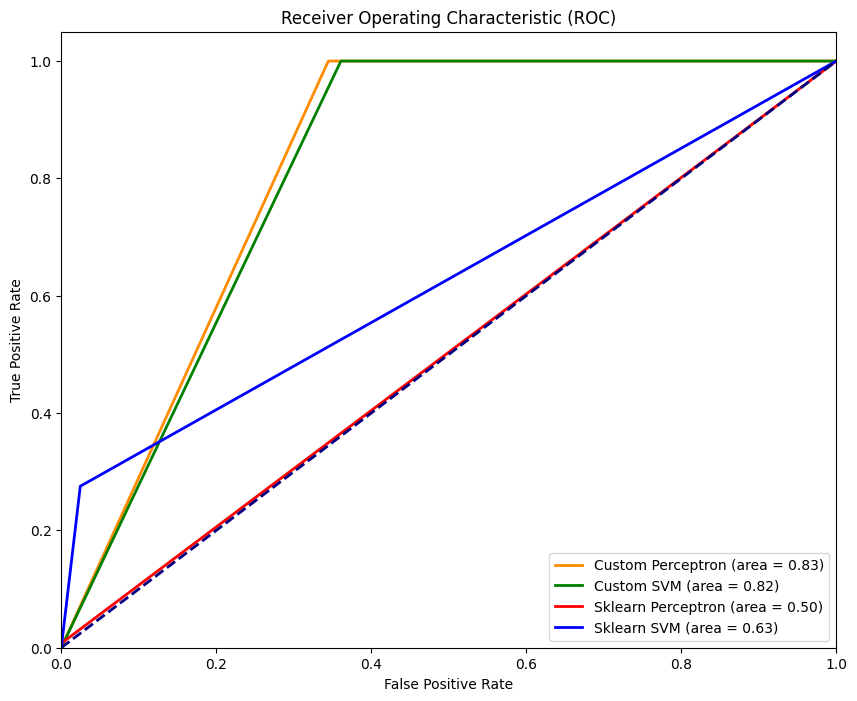

In [25]:

# Accuracy Scores


# Print the comparison table using tabulate
print("\nAccuracy Scores Comparison:")
print(tabulate(comparison_table, headers='keys', tablefmt='pretty', showindex=False))


# write metrics for every model now everything, if tables print it in tabular form, graphs is graphical, 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

# Custom Perceptron Metrics
custom_perceptron_report = classification_report(y, perceptron_predictions, output_dict=True)
custom_perceptron_df = pd.DataFrame(custom_perceptron_report).transpose()

# Custom SVM Metrics
custom_svm_report = classification_report(y, svm_predictions, output_dict=True)
custom_svm_df = pd.DataFrame(custom_svm_report).transpose()

# Sklearn Perceptron Metrics
sklearn_perceptron_report = classification_report(y, best_perceptron.predict(X), output_dict=True)
sklearn_perceptron_df = pd.DataFrame(sklearn_perceptron_report).transpose()

# Sklearn SVM Metrics
sklearn_svm_report = classification_report(y, best_svm.predict(X), output_dict=True)
sklearn_svm_df = pd.DataFrame(sklearn_svm_report).transpose()

# Custom Perceptron Metrics
print("Custom Perceptron Metrics:")
print(classification_report(y, perceptron_predictions))

# Custom SVM Metrics
print("Custom SVM Metrics:")
print(classification_report(y, svm_predictions))

# Sklearn Perceptron Metrics
print("Sklearn Perceptron Metrics:")
print(classification_report(y, best_perceptron.predict(X)))

# Sklearn SVM Metrics
print("Sklearn SVM Metrics:")
print(classification_report(y, best_svm.predict(X)))

# Print the ROC AUC scores
print("Custom Perceptron ROC AUC Score:", roc_auc_score(y, perceptron_predictions))
print("Custom SVM ROC AUC Score:", roc_auc_score(y, svm_predictions))
print("Sklearn Perceptron ROC AUC Score:", roc_auc_score(y, best_perceptron.predict(X)))
print("Sklearn SVM ROC AUC Score:", roc_auc_score(y, best_svm.predict(X)))

# Plot the ROC curves
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y, perceptron_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Custom Perceptron (area = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(y, svm_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green', lw=2, label='Custom SVM (area = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(y, best_perceptron.predict(X))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label='Sklearn Perceptron (area = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(y, best_svm.predict(X))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label='Sklearn SVM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


SVM SLACK Implementation

In [26]:
import numpy as np

class SoftMarginSVM:
    def __init__(self, learning_rate=0.01, epochs=1000, C=1.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.C = C  # Regularization parameter
        self.w = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        # Transform y to be in {-1, 1} for hinge loss
        y = np.where(y == 0, -1, 1)

        for epoch in range(self.epochs):
            # Compute hinge loss gradient
            margin = y * (X @ self.w)
            loss_gradient = self.w.copy()  # Regularization gradient
            for i in range(n_samples):
                if margin[i] < 1:  # Misclassified or within margin
                    loss_gradient -= self.C * y[i] * X[i]

            # Update weights
            self.w -= self.learning_rate * loss_gradient

            # Calculate hinge loss for monitoring
            hinge_loss = np.maximum(0, 1 - margin).sum() / n_samples
            regularization_loss = 0.5 * (self.w @ self.w)
            total_loss = regularization_loss + self.C * hinge_loss
            self.loss_history.append(total_loss)

    def predict(self, X):
        return np.sign(X @ self.w).astype(int)

# Example usage:
svm_with_slack = SoftMarginSVM(learning_rate=0.01, epochs=1000, C=1.0)
svm_with_slack.fit(X_with_intercept, y)
svm_predictions_with_slack = svm_with_slack.predict(X_with_intercept)


classification_report for the Soft-Margin SVM
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     34985
           1       0.22      1.00      0.36     10000

    accuracy                           0.22     44985
   macro avg       0.11      0.50      0.18     44985
weighted avg       0.05      0.22      0.08     44985



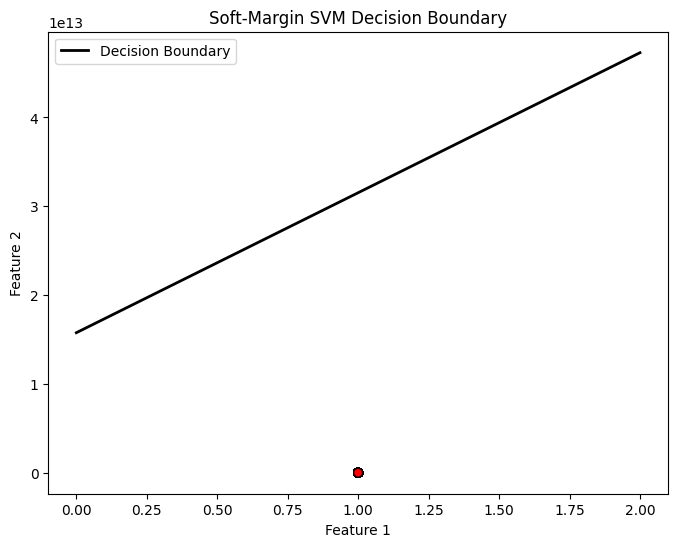

In [33]:
from sklearn.metrics import classification_report
#what is this report for meantion that also
# Print the classification report for the Soft-Margin SVM
print("classification_report for the Soft-Margin SVM")
print(classification_report(y, svm_predictions_with_slack))
#plot using scatter
plot_decision_boundary_scatter(X_with_intercept, y, svm_with_slack, 'Soft-Margin SVM Decision Boundary')



RBF Kernel Implementation on SVC

In [ ]:
from sklearn.svm import SVC

# Example of an SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_train, y_train)
#make prediction
y_pred = svm_rbf.predict(X_test)



Accuracy: 0.9147
Confusion Matrix:
[[10058   396]
 [  755  2287]]
ROC-AUC Score: 0.9633


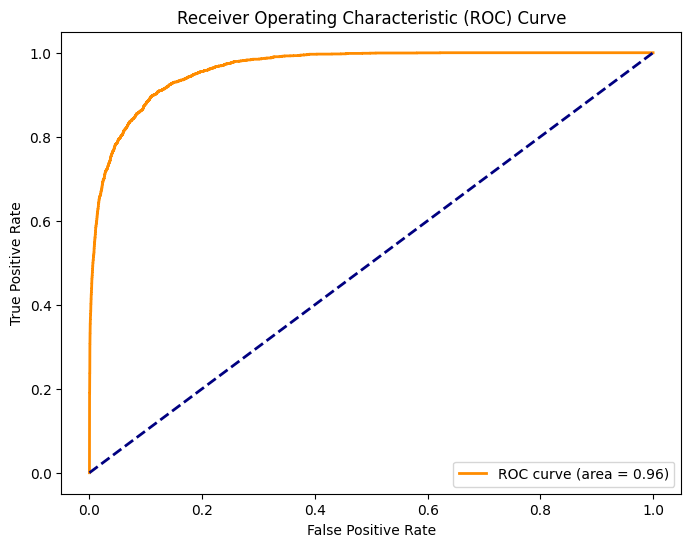

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.96      0.95     10454
           1       0.85      0.75      0.80      3042

    accuracy                           0.91     13496
   macro avg       0.89      0.86      0.87     13496
weighted avg       0.91      0.91      0.91     13496



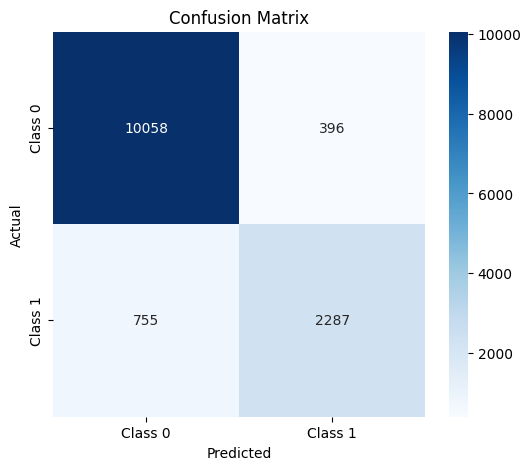

ValueError: X has 2 features, but SVC is expecting 30 features as input.

<Figure size 800x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import seaborn as sns

# Assuming you have already trained your SVM with an RBF kernel (svm_rbf)
# and have X_test and y_test ready.

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, svm_rbf.decision_function(X_test))
print(f"ROC-AUC Score: {roc_auc:.4f}")
#plot the curve ROC-AUC
fpr, tpr, _ = roc_curve(y_test, svm_rbf.decision_function(X_test))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# Classification Report (precision, recall, F1-score)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

